In [1]:
import ee 
import folium
import geehydro
from datetime import datetime as dt
from IPython.display import Image
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np

In [2]:
# Autheticate and then initialize the session using your credentials
#ee.Authenticate()
ee.Initialize()

In [126]:
def return_time_series_collection(start_time='2000-01-01',end_time='2018-01-01',
                       data_source='LANDSAT/LC8_L1T_TOA',
                       cloud_cover=5,
                       input_bands=['B4','B5','B6'],
                       roi = [5.727906, 51.993435,
                                 5.588144, 51.944356]):
    '''
    Time: yyyy-mm-dd
    roi: Region-of-interest
    
    '''
    
    ## Define your image collection 
    collection = ee.ImageCollection(data_source)
    
    ## Define time range and filter the data
    collection_time = collection.filterDate(start_time, end_time) #YYYY-MM-DD
    
    x0,y0,x1,y1 = roi
    
    ROI = ee.Geometry.Rectangle([x0,y0,
                                 x1,y1])
    
    
    
    #collection_time = collection_time.filter(ee.Filter.eq('WRS_PATH', 198))
    #collection_time = collection_time.filter(ee.Filter.eq('WRS_ROW', 24))
    
    # Filter by a specific region
    filterRegion = collection_time.filterBounds(ROI)
    
    ## Select imagery with less then 5% of image covered by clouds
    clouds = filterRegion.filter(ee.Filter.lt('CLOUD_COVER', cloud_cover))
    
    ## Select bands
    bands = clouds.select(input_bands)
    
    eeCollection = bands
    
    collectionList = bands.toList(bands.size()) # Converts the image collection to a list accessible via index
    collectionSize = collectionList.size().getInfo()
    
    # Get the information about the dates of this collection 'SENSING_TIME'
    #collectionDates = [ee.Image(collectionList.get(indx)).getInfo()['properties']['DATE_ACQUIRED'] for indx in range(collectionSize)]
    
    # For the new data
    collectionDates = [ee.Image(collectionList.get(indx)).getInfo()['properties']['SENSING_TIME'] for indx in range(collectionSize)]
    
    
    return collectionSize,collectionList,collectionDates,eeCollection


def normalize(data):
    '''
    Normalize the data from 0->1
    '''
    
    norm = (data-data.min())/(data.max()-data.min())
    
    return norm

def convert_image_to_numpy(image,
                           roi=[5.727906, 51.993435,
                                5.588144, 51.944356],
                           input_bands=['B4','B5','B6'],
                          normalized=True):
    '''
    Converts a single image in the collection List to a numpy array
    
    
    This only works for smaller satellite image regions
    
    '''
    
    
    #image = ee.Image(collectionList.get(indx))
    ROI = ee.Geometry.Rectangle(roi)
    
    band_arrs = image.sampleRectangle(region=ROI,defaultValue=0)
    #band_arrs = image.stratifiedSample(region=ROI)
    
    img_arrays = [ np.array(band_arrs.get(band).getInfo()) for band in input_bands]
    
    # Rescale the arrays
    if(normalized==True):
        img_arrays = [normalize(img_array) for img_array in img_arrays]
    
    img_arrays = [np.expand_dims(img_array, 2) for img_array in img_arrays]
    rgb_img = np.concatenate(img_arrays, 2)
    
    
    return rgb_img

def convert_collection_to_numpy(roi,collectionSize,collectionList,collectionDates):
    '''
    Converts all of the images in a collection to numpy matrices,
    and filters 
    '''
    ROI = ee.Geometry.Rectangle(roi)
    
    for k in range(collectionSize):
        image = ee.Image(collectionList.get(k))
        
        try:
            band_arrs = image.sampleRectangle(region=ROI)
        except:
            pass
    
    
    return newCollectionSize,newCollectionList,newCollectionDates


def train_Kmeans_classifier(img,K,roi):
    '''
    This simple function trains a K-means classifier on an image
    '''
    
    input = ee.Image(img)
    
    ROI = ee.Geometry.Rectangle(roi)
    
    # Make the training dataset.
    training = input.sample(**{
        'region': ROI,
        'scale': 30,
        'numPixels': 5000
    })

    # Instantiate the clusterer and train it.
    clusterer = ee.Clusterer.wekaKMeans(K).train(training)
    
    return clusterer


def count_pixels_per_class(img,K,classifier,vec):
    '''
    This function counts the number of pixels in 
    an image of a certain class
    '''
    
    results = np.zeros(K)
    
    # Cluster the input using the trained clusterer.
    result = img.cluster(classifier)
    
    ROI = ee.Geometry.Rectangle(vec)
    band_arrs = result.sampleRectangle(region=ROI,defaultValue=0)
    data = np.array(band_arrs.get('cluster').getInfo())
    
    for k in range(K):
        results[k] = np.sum(data.flatten()==k)
        
    results = results/np.sum(results)
    
    return results

def count_pixels_per_class(img,K,classifier,vec):
    '''
    This function counts the number of pixels in 
    an image of a certain class
    '''
    
    results = np.zeros(K)
    
    # Cluster the input using the trained clusterer.
    result = img.cluster(classifier)
    
    ROI = ee.Geometry.Rectangle(vec)
    band_arrs = result.sampleRectangle(region=ROI,defaultValue=0)
    data = np.array(band_arrs.get('cluster').getInfo())
    
    for k in range(K):
        results[k] = np.sum(data.flatten()==k)
        
    results = results/np.sum(results)
    
    return results

def count_pixels_per_class_X(data,K):
    
    
    results = np.zeros(K)
    
    for k in range(K):
        results[k] = np.sum(data.flatten()==k)
        
    results = results/np.sum(results)
    
    
    return results



In [214]:
#vec = [5.727906, 51.993435, 5.588144, 51.944356]


bands = ['B3','B2','B1'] #LSAT7
#bands = ['B4','B3','B2'] # LSAT8#
#
#vec = [133.35830,-31.372,133.455539,-31.326256]
#vec = [5.727906, 51.993435,5.588144, 51.944356]
#vec = [-10.794301,-62.328798,-10.820638,-62.368717]
vec = [-62.387346,-10.812397,-62.306727,-10.759789] # Deforestation in Brazil


# Old collection: LANDSAT/LC8_L1T_TOA
# New collection: LANDSAT/LC08/C01/T1_SR
# collectionSize,collectionList,collectionDates = return_time_series_collection(start_time='2014-01-01',
#                     end_time='2019-01-01',
#                     data_source='LANDSAT/LC8_L1T_TOA',
#                     cloud_cover=20,
#                     input_bands=bands,roi=vec )

# Para south parah 

# LANDSAT/LE07/C01/T1_SR
# Good data: LANDSAT/LE07/C01/T1_SR
# Bad data: LANDSAT/LE07/C01/T1
#LANDSAT/LE07/C01/T1_SR'


# LANDSAT/LT05/C01/T1_SR
collectionSize,collectionList,collectionDates,eeCollection = return_time_series_collection(start_time='1990-01-01',
                    end_time='2010-01-01',
                    data_source='LANDSAT/LT05/C01/T1_SR',
                    cloud_cover=1,
                    input_bands=bands,roi=vec )



print('='*100)
print('Dates:' )
print(collectionDates)
print('Length: ')
print(collectionSize)
print('='*100)


ROI = ee.Geometry.Rectangle(vec)


# Define the region of interest
#ROI = ee.Geometry.Rectangle(vec)
    
# Choose a specific image from the collection List
indx = 2

image = ee.Image(collectionList.get(indx))

parameters = {'min': 0,
               'max':100,
               'bands': bands,
               'region': ROI }

# Plot the satellite image
Image(url = image.getThumbUrl(parameters))

{'IMAGE_QUALITY': 9, 'SATELLITE': 'LANDSAT_5', 'SOLAR_AZIMUTH_ANGLE': 51.81044, 'CLOUD_COVER': 0, 'WRS_PATH': 231, 'EARTH_SUN_DISTANCE': 1.016142, 'system:time_start': 648480899410, 'LANDSAT_ID': 'LT05_L1TP_231067_19900720_20170130_01_T1', 'SENSING_TIME': '1990-07-20T13:34:59.4100000Z', 'ESPA_VERSION': '2_19_0c', 'SOLAR_ZENITH_ANGLE': 49.91478, 'system:footprint': {'type': 'LinearRing', 'coordinates': [[-63.15370771419346, -10.770602869293905], [-63.15535966472434, -10.779560650308598], [-63.15848859901534, -10.797504651237068], [-63.15742491269381, -10.801016509233015], [-61.48123379647352, -11.044855465890317], [-61.469279777542525, -10.99290952487145], [-61.34438325122019, -10.410759137723668], [-61.219788108654896, -9.82861294196664], [-61.15233478155403, -9.511478917556785], [-61.13607560062895, -9.432929368887706], [-61.13700096355288, -9.430816760763193], [-61.4842792949823, -9.380924499865127], [-61.88820064143325, -9.322467140543889], [-62.31225668602419, -9.26059035486476], [

In [215]:
ts_dates = []
X = []
indx_mapping = np.zeros(collectionSize)

count = 0

for i in range(0,collectionSize):
    image = ee.Image(collectionList.get(i))
    
    try:
        data= convert_image_to_numpy(image,roi=vec,input_bands=bands,normalized=True)
        
        X.append(data)
        ts_dates.append(collectionDates[i])
        indx_mapping[i] = count
        count+=1
    except Exception as e:
        print('Exception!: ',i)
        pass

ts_dates = np.array(ts_dates)
time_series = np.array(time_series)

/home/oscar/.local/lib/python3.6/site-packages/ipykernel_launcher.py:18: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.


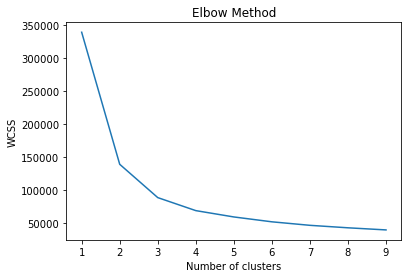

In [216]:
from sklearn.cluster import KMeans

Kmax = 10

X = np.array(X)
X_train = X.reshape(-1,3)

wcss = []
for i in range(1, Kmax):
    kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=0)
    kmeans.fit(X_train)
    wcss.append(kmeans.inertia_)
    
plt.plot(range(1, Kmax), wcss)
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

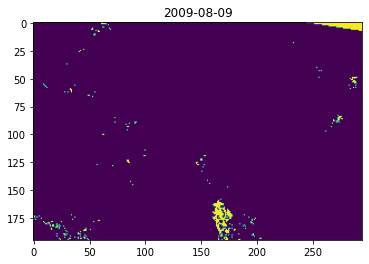

In [221]:

K=5

# Train the K-means classifier
kmeans = KMeans(n_clusters=K, init='k-means++', max_iter=300, n_init=10, random_state=0)
kmeans.fit(X_train)

# Store the percentages of all the classes
percent_classes_array = []



time_raw = np.array([date.split('T')[0] for date in ts_dates])


for k in range(0,len(X)):
    X_test = X[k]
    pred_y = kmeans.predict(X_test.reshape(-1,3))
    pred_y = pred_y.reshape(X_test.shape[0],X_test.shape[1])
    percent_classes_array.append(count_pixels_per_class_X(pred_y,K=4))
    
    plt.clf()
    plt.title(time_raw[k])
    plt.imshow(X_test)
    plt.savefig('sat/img_'+str(k)+'.png')
    
    plt.clf()
    plt.title(time_raw[k])
    plt.imshow(pred_y==1)
    plt.savefig('kmeans/kmeans_img_'+str(k)+'.png')
    
    
    
    
        
percent_classes_array = np.array(percent_classes_array)

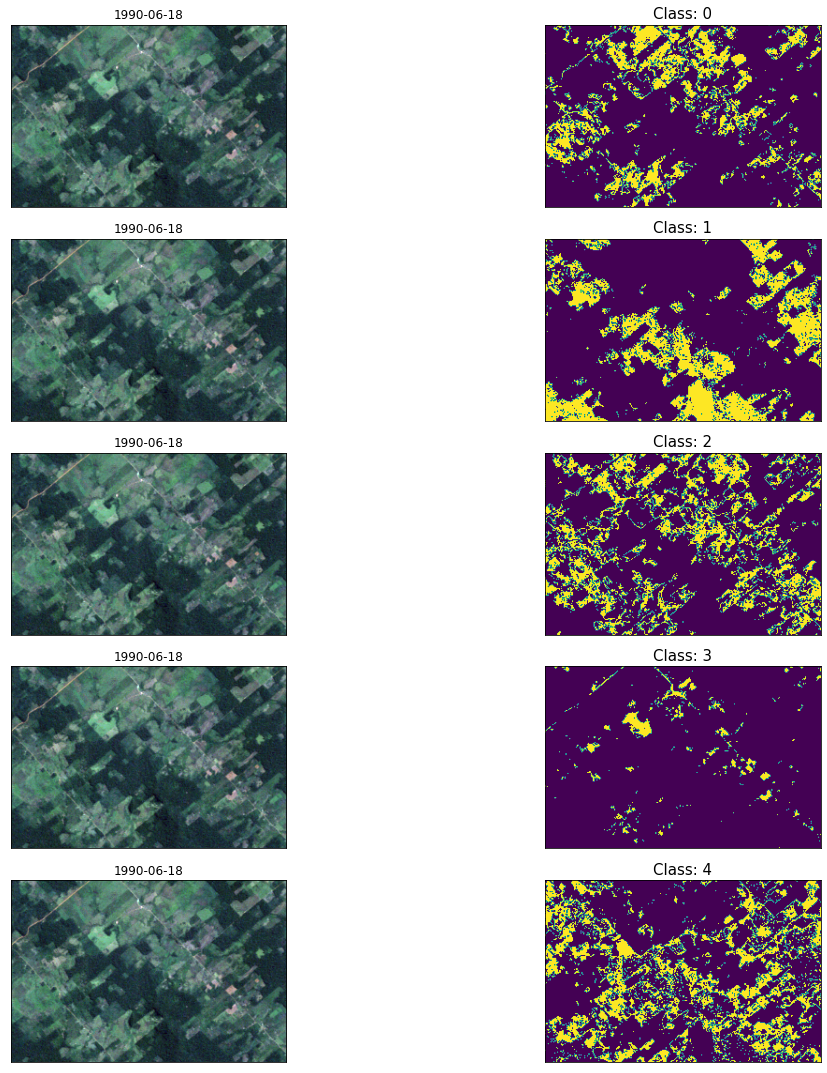

In [532]:
indx_example = 0
X_test = X[indx_example]
pred_y = kmeans.predict(X_test.reshape(-1,3))
pred_y = pred_y.reshape(X_test.shape[0],X_test.shape[1]) 

f, axarr = plt.subplots(K,2)
f.set_figheight(15)
f.set_figwidth(15)
f.tight_layout()

for k in range(K):
    axarr[k,0].set_title(time_raw[indx_example])
    axarr[k,0].imshow(X_test)
    axarr[k,0].get_xaxis().set_visible(False)
    axarr[k,0].get_yaxis().set_visible(False)
    
    axarr[k,1].set_title('Class: '+str(k),size=15)
    axarr[k,1].imshow(pred_y==k)
    axarr[k,1].get_xaxis().set_visible(False)
    axarr[k,1].get_yaxis().set_visible(False)
    

42 42


/home/oscar/.local/lib/python3.6/site-packages/ipykernel_launcher.py:66: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.


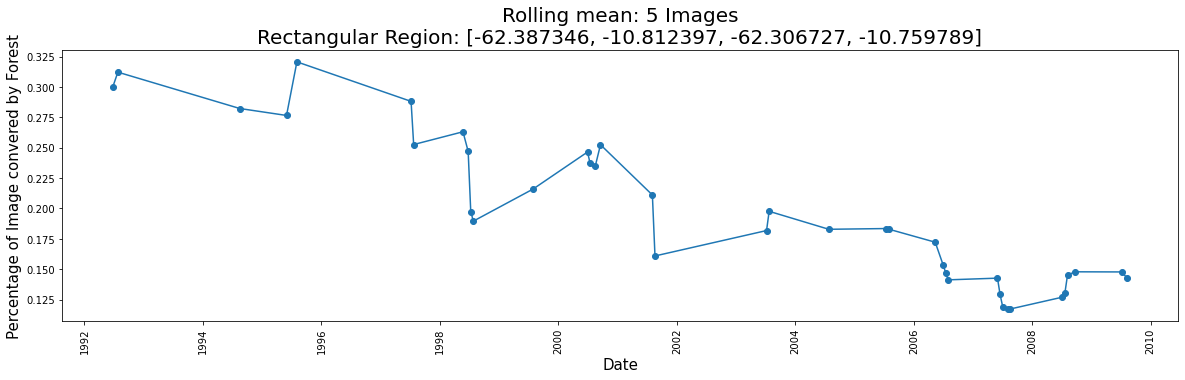

In [582]:
import pandas as pd

# Choose the class to focus on
k=1

ndays = 5
ymax = 0.45
ymin = 0.1

time_raw = np.array([date.split('T')[0] for date in ts_dates])
yt_raw = percent_classes_array[:,k].flatten()


time_raw_filtered = []
yt_raw_filtered = []
index_raw_filtered = []

# Filter out duplicate data
for i in range(len(time_raw)):
    
    yk = yt_raw[i]
    tk = time_raw[i]
    
    if(tk not in time_raw_filtered):
        time_raw_filtered.append(tk)
        yt_raw_filtered.append(yk)
        index_raw_filtered.append(i)

# Filtered to make them unique
time_raw_filtered = np.array(time_raw_filtered)
yt_raw_filtered = np.array(yt_raw_filtered)
index_raw_filtered = np.array(index_raw_filtered)


    
# Filter the data according to a threshold value
index_raw_filtered = index_raw_filtered[(yt_raw_filtered<=ymax)]
time = time_raw_filtered[(yt_raw_filtered<=ymax)]
yt = yt_raw_filtered[(yt_raw_filtered<=ymax)]



index_raw_filtered = index_raw_filtered[(yt>=ymin)]
time = time[(yt>=ymin)]
yt = yt[(yt>=ymin)]


print(len(index_raw_filtered),len(time))

# convert to data frame in order to filter data by date
df = pd.DataFrame()

df['T'] = time
df['index'] = index_raw_filtered
df['T'] = pd.to_datetime(df['T'], format="%Y-%m-%d")
df['yt']=yt
df=df.sort_values(by=['T'])


plt.figure(figsize=(20,5))
plt.title('Rolling mean: ' + str(ndays)+' Images' +'\n'+'Rectangular Region: '+str(vec[:]),size=20)
plt.plot(df['T'],df['yt'].rolling(window=ndays).mean(),'-o')
plt.ylabel('Percentage of Image convered by Forest',size=15)
plt.xlabel('Date',size=15)
plt.xticks(rotation='90')
plt.show()

In [568]:
# Generate a properly ordered video sequence !

time_raw = np.array([date.split('T')[0] for date in ts_dates])

count=0

for k in df['index'].values:
    X_test = X[k]
    pred_y = kmeans.predict(X_test.reshape(-1,3))
    pred_y = pred_y.reshape(X_test.shape[0],X_test.shape[1])
    
    plt.clf()
    plt.figure(figsize=(20,10))
    plt.title(time_raw[k],size=20)
    plt.imshow(X_test)
    plt.axis('off')
    plt.savefig('sat/img_'+str(count)+'.png',bbox_inches='tight')
    plt.close()
    
    plt.clf()
    plt.figure(figsize=(20,10))
    plt.title(time_raw[k],size=20)
    plt.imshow(pred_y==1)
    plt.axis('off')
    plt.savefig('kmeans/kmeans_img_'+str(count)+'.png',bbox_inches='tight') 
    plt.close()
    count+=1

<Figure size 432x288 with 0 Axes>

In [577]:
# Generate a properly ordered video sequence !

time_raw = np.array([date.split('T')[0] for date in ts_dates])


f, axarr = plt.subplots(1,2)
f.set_figheight(15)
f.set_figwidth(15)
f.tight_layout()
count=0

for k in df['index'].values:
    X_test = X[k]
    
    pred_y = kmeans.predict(X_test.reshape(-1,3))
    pred_y = pred_y.reshape(X_test.shape[0],X_test.shape[1])
    
    plt.clf()
    f, axarr = plt.subplots(1,2)
    f.set_figheight(15)
    f.set_figwidth(15)
    f.tight_layout()
    axarr[0].set_title(time_raw[k],size=20)
    axarr[0].imshow(X_test)
    axarr[0].get_xaxis().set_visible(False)
    axarr[0].get_yaxis().set_visible(False)
    
    axarr[1].set_title('Class: Forest',size=15)
    axarr[1].imshow(pred_y==1)
    axarr[1].get_xaxis().set_visible(False)
    axarr[1].get_yaxis().set_visible(False)
    plt.savefig('kmeans/kmeans_img_'+str(count)+'.png',bbox_inches='tight')
    plt.close()
    count+=1

<Figure size 1080x1080 with 0 Axes>

In [544]:
!conda install gdal -y

Solving environment: - ^C
| 

# Determine the rate of deforestation using linear regression

# The MLE-way

[ 6.66538074e-05 -1.25881722e-02  3.37982813e-01]


/home/oscar/.local/lib/python3.6/site-packages/ipykernel_launcher.py:35: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.


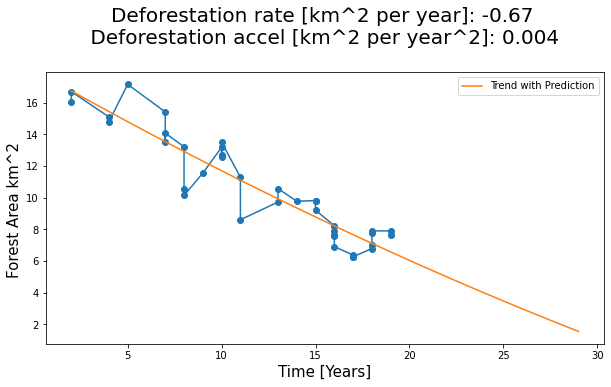

In [595]:
import datetime

# From Sascha
Area = 53.5023717 # km^2 
#Area = 53.5023717*1000**2 # m^2

y1 = np.array(df['yt'].rolling(window=ndays).mean().values).flatten()

# We convert this array into 'Years'
x1 = np.array((df['T'].values-df['T'].values[0]).astype('timedelta64[Y]').astype(float)).flatten()


# Filter out any NAN values for fitting the polynomial
x1=x1[(np.isnan(y1)==False)]
y1=y1[(np.isnan(y1)==False)]

z1 = np.polyfit(x1, y1, 2)
p = np.poly1d(z1)

print(z1)

xnew = np.linspace(x1[0],x1[-1]+10)
#ynew = np.linspace(x1[0],x1[-1]+10)


title = 'Deforestation rate [km^2 per year]: {} \n Deforestation accel [km^2 per year^2]: {} \n'.format(round(p[1]*Area,2),round(p[2]*Area,3))

plt.figure(figsize=(10,5))
plt.title(title,size=20)
plt.plot(x1,Area*y1,'-o')
plt.plot(xnew,Area*p(xnew),label='Trend with Prediction')
plt.ylabel('Forest Area km^2 ',size=15)
plt.xlabel('Time [Years]',size=15)
plt.legend()
plt.show()

# Determine the rate of deforestation using linear regression
# The Bayesian way

In [500]:
# Determine the rate of deforestation using linear regression
# The MLE-way
import emcee

# model = a*x**2+b*x+c

def log_prior(theta):
    '''
    Uniform priors on the parameters
    '''
    a, b, c,sigma = theta
    
    if -1.0 < a < 1.0 and -1.0 < b < 1.0 and -1.0 < c < 1.0 and 0.0 <sigma < 10:
        return 0.0
    return -np.inf

def log_likelihood(theta, x, y):
    a, b, c,sigma = theta
    model = a*x**2+b*x+c
    #model = b*x+c
    #return -0.5 * np.sum((y - model) ** 2)
    return -0.5 * np.sum((y - model) ** 2 / sigma**2 + np.log(sigma**2))

def log_probability(theta, x, y):
    lp = log_prior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood(theta, x, y)

res = (y1-p(x1))
pos =  [p[0],p[1],p[2],res.std()] + 1e-4 * np.random.randn(32, 4)
nwalkers, ndim = pos.shape

sampler = emcee.EnsembleSampler(nwalkers, ndim, log_probability, args=(x1, y1))
sampler.run_mcmc(pos, 5000, progress=True);

100%|██████████| 5000/5000 [00:05<00:00, 962.52it/s]


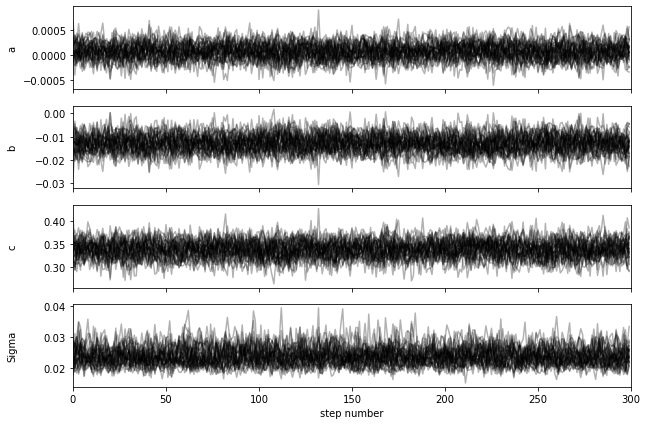

In [501]:
fig, axes = plt.subplots(4, figsize=(10, 7), sharex=True)
samples = sampler.get_chain(discard=500, thin=15)
labels = ["a", "b", "c",'Sigma']
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number");

/home/oscar/.local/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.
  


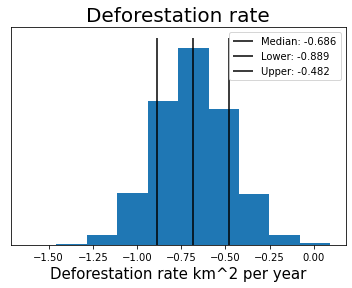

In [617]:
plt.clf()
plt.title('Deforestation rate',size=20)
mcmc = np.percentile(Area*flatsamples[:, 1], [16, 50, 84])


plt.hist(Area*flatsamples[:,1],density=True)
xmin, xmax, ymin, ymax = plt.axis()
plt.vlines(mcmc[1],ymin=0.0,ymax=ymax,label='Median: '+str(round(mcmc[1],3)))
plt.vlines(mcmc[0],ymin=0.0,ymax=ymax,label='Lower: '+str(round(mcmc[0],3)))
plt.vlines(mcmc[2],ymin=0.0,ymax=ymax,label='Upper: '+str(round(mcmc[2],3)))
plt.xlabel('Deforestation rate km^2 per year',size=15)
plt.yticks([])
plt.legend()
plt.show()

/home/oscar/.local/lib/python3.6/site-packages/ipykernel_launcher.py:15: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.
  from ipykernel import kernelapp as app


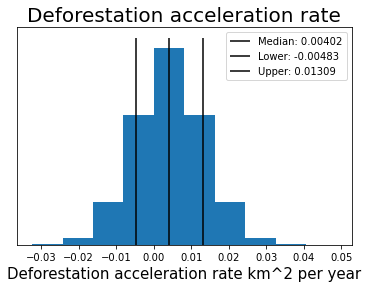

In [616]:
flatsamples=np.array(samples.reshape(-1,4))
#print(flatsamples.shape)


plt.title('Deforestation acceleration rate',size=20)
mcmc = np.percentile(Area*flatsamples[:, 0], [16, 50, 84])
plt.hist(Area*flatsamples[:,0],density=True)
xmin, xmax, ymin, ymax = plt.axis()
plt.vlines(mcmc[1],ymin=0.0,ymax=ymax,label='Median: '+str(round(mcmc[1],5)))
plt.vlines(mcmc[0],ymin=0.0,ymax=ymax,label='Lower: '+str(round(mcmc[0],5)))
plt.vlines(mcmc[2],ymin=0.0,ymax=ymax,label='Upper: '+str(round(mcmc[2],5)))
plt.yticks([])
plt.xlabel('Deforestation acceleration rate km^2 per year',size=15)
plt.legend()
plt.show()

No handles with labels found to put in legend.
/home/oscar/.local/lib/python3.6/site-packages/ipykernel_launcher.py:33: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.


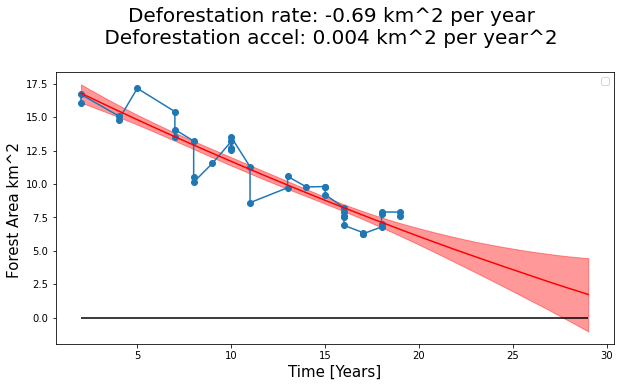

In [618]:

ypred_min = []
ypred_max = []
ypred_median = []

for xk in xnew:
    model_k = flatsamples[:,0]*xk**2+flatsamples[:,1]*xk+flatsamples[:,2]
    mcmc = np.percentile(model_k, [16, 50, 84])
    ypred_min.append(mcmc[0])
    ypred_max.append(mcmc[2])
    ypred_median.append(mcmc[1])
    
ypred_max = np.array(ypred_max)
ypred_median = np.array(ypred_median)
ypred_min = np.array(ypred_min)
    

    
mcmc_a = np.percentile(flatsamples[:,0], [16, 50, 84])
mcmc_b = np.percentile(flatsamples[:,1], [16, 50, 84])
mcmcm_c = np.percentile(flatsamples[:,2], [16, 50, 84])

title = 'Deforestation rate: {} km^2 per year \n Deforestation accel: {} km^2 per year^2  \n'.format(round(mcmc_b[1]*Area,2),round(mcmc_a[1]*Area,3))

plt.figure(figsize=(10,5))
plt.title(title,size=20)
plt.plot(x1,Area*y1,'-o')
plt.fill_between(xnew,Area*ypred_min,Area*ypred_max,alpha=0.4,color='r')
plt.plot(xnew,Area*ypred_median,'r')
plt.hlines(y=0.0,xmin=xnew[0],xmax=xnew[-1],linestyles='-')
plt.ylabel('Forest Area km^2 ',size=15)
plt.xlabel('Time [Years]',size=15)
plt.legend()
plt.show()

/home/oscar/.local/lib/python3.6/site-packages/ipykernel_launcher.py:20: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.


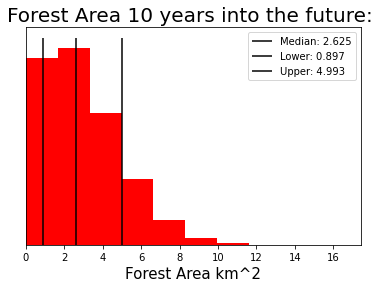

In [612]:
flatsamples=np.array(samples.reshape(-1,4))

future_years = 10
#time_point = x1[-1]+5

model = flatsamples[:,0]*(x1[-1]+future_years)**2+flatsamples[:,1]*(x1[-1]+future_years)+flatsamples[:,2]
model = model[model>0.0]

plt.title('Forest Area {} years into the future: '.format(future_years),size=20)
mcmc = np.percentile(Area*model, [16, 50, 84])
plt.hist(Area*model,density=True,color='r')
xmin, xmax, ymin, ymax = plt.axis()
plt.vlines(mcmc[1],ymin=0.0,ymax= ymax,label='Median: '+str(round(mcmc[1],3)))
plt.vlines(mcmc[0],ymin=0.0,ymax=ymax,label='Lower: '+str(round(mcmc[0],3)))
plt.vlines(mcmc[2],ymin=0.0,ymax=ymax,label='Upper: '+str(round(mcmc[2],3)))
plt.xlim(0.0,xmax)
plt.xlabel('Forest Area km^2',size=15)
plt.yticks([])
plt.legend()
plt.show()

In [ ]:
# Make an image